In [87]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 30 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 60
cfg['set_id'] = 8

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [88]:
from dataloader import *
from models import *
import time

model = LSTM_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [89]:
model.train()

LSTM_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (lstm): LSTM(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [90]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 404.61116
count = 4, loss = 236.92122
count = 6, loss = 78.97780
validation loss: 52.764381408691406
epoch finished: 1
count = 2, loss = 57.45841
count = 4, loss = 39.59410
count = 6, loss = 36.77600
validation loss: 25.31671142578125
epoch finished: 2
count = 2, loss = 25.13806
count = 4, loss = 27.31692
count = 6, loss = 22.45058
validation loss: 17.568395614624023
epoch finished: 3
count = 2, loss = 22.12722
count = 4, loss = 16.10992
count = 6, loss = 21.15410
validation loss: 13.388093948364258
epoch finished: 4
count = 2, loss = 16.18398
count = 4, loss = 14.75019
count = 6, loss = 16.87109
validation loss: 11.528581619262695
epoch finished: 5
count = 2, loss = 15.50183
count = 4, loss = 15.43461
count = 6, loss = 15.67451
validation loss: 15.500371932983398
epoch finished: 6
count = 2, loss = 16.55075
count = 4, loss = 16.88314
count = 6, loss = 13.75989
validation loss: 13.51211166381836
epoch finished: 7
count = 2, loss = 13.39723
count = 4, loss = 17.58488
c

In [26]:
np.save('val_loss_set7.npy', val_losses)
np.save('train_loss_set7.npy', train_losses)

In [103]:
model = load_model(LSTM_Score, './models/s8_ba120e28b6.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [107]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 18.986696243286133
validation MAE: 0.060529209673404694
QWK Score: 0.5735895869206984


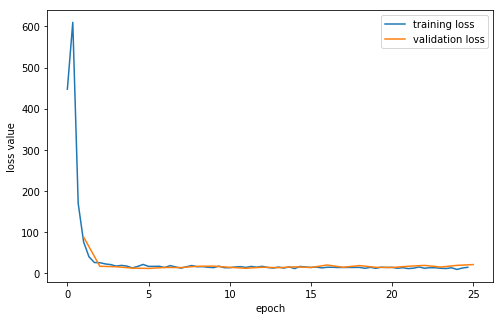

In [84]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [34]:
targets

[array([17, 13, 13, 16, 18, 17, 23, 24,  9, 19, 10, 19, 19, 19,  8, 19, 11,
        19, 18, 21, 14, 16, 17, 19, 18, 15, 13, 15, 11, 13, 19, 17, 17, 16,
        16, 13, 21, 24, 15, 17, 11, 18, 19, 21,  9, 16, 11, 14, 14, 20, 17,
        18, 21, 16,  9, 16, 16, 15, 13, 15, 14, 18, 18, 18, 21, 18, 13, 15,
        15, 14, 18, 15, 15, 21, 15, 11, 17, 20, 12, 16, 15, 20, 19, 13, 15,
         9, 19, 20, 15, 18, 21, 13, 21, 21, 16, 22, 13, 12, 15, 15, 17, 13,
        15, 16, 21, 13, 16, 22, 17, 13, 17, 19, 12, 20, 19, 12, 16, 10, 16,
        20]),
 array([13, 19, 16, 19,  9, 23, 17, 12, 19, 17, 23, 21, 18, 18, 12, 17, 20,
        11, 17, 20, 15, 17,  9, 17, 14, 10, 17, 16, 22, 17, 20, 18, 17, 14,
        13, 17, 10, 21, 10, 13, 18, 11, 12, 20, 15, 18,  8, 15, 14, 19, 17,
        21, 14, 16, 20, 14, 14, 19, 16, 15, 21,  4,  9, 21, 20, 17, 11, 13,
        12, 13, 18, 17,  7, 17, 15, 18, 17, 18, 22, 14, 17, 23, 19,  6, 13,
        15,  8, 18, 14, 16, 16, 17, 18, 18, 18, 16, 20, 22, 16, 19, 20, 18

In [35]:
preds

[array([13, 18, 11, 19, 24, 21, 24, 26, 11, 16, 12, 20, 18, 18, 12, 21, 11,
        20, 18, 24, 15, 14, 15, 18, 20, 20, 13, 16, 14, 16, 16, 15, 20, 18,
        13, 15, 18, 24, 14, 19, 11, 23, 23, 20, 11, 19, 11, 15, 21, 14, 15,
        19, 19, 15, 13, 15, 20, 13, 13, 13, 15, 17, 17, 18, 17, 17, 15, 15,
        14, 17, 19, 14, 14, 25, 14, 13, 14, 21, 15, 14, 12, 21, 20, 12, 17,
        15, 21, 18, 15, 26, 25, 16, 26, 21, 18, 20, 11, 14, 17, 14, 10, 15,
        15, 15, 20, 12, 13, 23, 14, 11, 15, 18, 12, 23, 23, 11, 14, 14, 11,
        17]),
 array([12, 25, 13, 18, 13, 23, 16, 13, 19, 19, 23, 21, 17, 16, 15, 13, 18,
        15, 14, 14, 13, 17, 13, 16, 16, 10, 16, 14, 22, 18, 19, 18, 16, 14,
        14, 13, 13, 19, 11, 12, 18, 13, 11, 25, 18, 15, 11, 15, 12, 19, 18,
        16, 16, 11, 18, 13, 14, 19, 17, 12, 22, 10, 11, 21, 17, 17, 12, 15,
        21, 15, 13, 13, 12, 16, 14, 12, 17, 18, 20, 13, 15, 27, 20, 10, 10,
        12, 13, 14, 17, 17, 16, 18, 21, 16, 17, 16, 18, 23, 20, 16, 21, 16

In [36]:
train_losses

[58.826128005981445,
 83.82226181030273,
 27.976672172546387,
 8.894947052001953,
 9.069005966186523,
 10.545665264129639,
 9.270501136779785,
 8.492339611053467,
 9.648960590362549,
 8.848365783691406,
 9.652031421661377,
 8.256037473678589,
 9.562288761138916,
 8.483932733535767,
 8.139464616775513,
 8.211259841918945,
 8.017834424972534,
 8.596305847167969,
 8.492496013641357,
 8.831454753875732,
 7.869187355041504,
 7.592872142791748,
 7.414953231811523,
 8.365462064743042,
 6.932265281677246,
 8.828537702560425,
 8.715993642807007,
 7.092219591140747,
 8.43921184539795,
 7.165631532669067,
 8.213889122009277,
 8.215910911560059,
 8.279595375061035,
 8.47982406616211,
 8.113431930541992,
 8.050251245498657,
 8.171157836914062,
 7.718775033950806,
 7.2072978019714355,
 7.218355417251587,
 7.78033709526062,
 7.801320314407349,
 7.185112714767456,
 7.91815972328186,
 7.751954793930054,
 6.64454984664917,
 8.170000791549683,
 7.336502313613892,
 7.500473499298096,
 6.540250778198242,
 

In [38]:
val_losses

[5.507206916809082,
 6.583305676778157,
 6.606971263885498,
 7.154703934987386,
 8.072858651479086,
 6.867302417755127,
 7.285458564758301,
 6.8923600514729815,
 8.062660058339437,
 7.394241491953532,
 6.693247159322103,
 7.263799985249837,
 8.851490020751953,
 9.067911942799887,
 8.062322775522867,
 8.374730587005615,
 7.981822808583577,
 9.317164738972982,
 9.763256867726644,
 7.560497919718425,
 9.768914540608725,
 6.7968831062316895,
 8.456090132395426,
 9.263880729675293,
 9.422356923421225]